In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|████████████████████████████████████████████████████| 27330/27330 [00:03<00:00, 8201.66it/s]


# Creating train,val,test sets

## Removing outliers

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score,txt_label
0,/home/kalfasyan/data/images/sticky_plates/phot...,3,2020_UNDISTORTED_herent_w30_3-30_4056x3040.png...,UNDISTORTED_herent_w30_3-30_4056x3040.png,2020,herent,w30,3-30,12149,40.965774,...,63.750000,28.549411,90.591459,33.946445,198.294216,185.672539,185.721457,0,0.133439,t
1,/home/kalfasyan/data/images/sticky_plates/phot...,3,2020_UNDISTORTED_herent_w33_1-60_4056x3040.jpg...,UNDISTORTED_herent_w33_1-60_4056x3040.jpg,2020,herent,w33,1-60,20008,81.875010,...,62.928571,44.364471,70.205020,51.203421,215.880444,204.308267,205.085111,0,0.239303,t
3,/home/kalfasyan/data/images/sticky_plates/phot...,3,2020_herent_w31_1-90_4056x3040.jpg_t_26135,herent_w31_1-90_4056x3040.jpg,2020,herent,w31,1-90,26135,84.741064,...,74.653846,28.266383,138.095199,33.174415,204.264984,192.322118,188.691717,0,0.348769,t
4,/home/kalfasyan/data/images/sticky_plates/phot...,3,2020_herent_w31_3-30_4056x3040.jpg_t_8818,herent_w31_3-30_4056x3040.jpg,2020,herent,w31,3-30,8818,36.242744,...,110.583333,51.748737,123.093940,40.941169,196.144978,192.982444,198.214133,0,0.105268,t
6,/home/kalfasyan/data/images/sticky_plates/phot...,3,2020_UNDISTORTED_herent_w32_3-60_4056x3040.jpg...,UNDISTORTED_herent_w32_3-60_4056x3040.jpg,2020,herent,w32,3-60,14824,18.117225,...,53.700000,34.922034,37.452103,12.384586,221.163400,210.200179,210.320358,0,0.162444,t


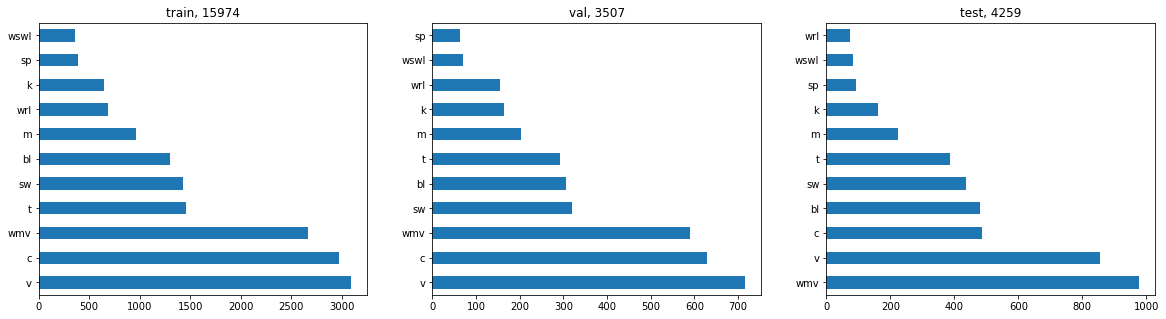

In [5]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(11).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [7]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [8]:
df_train.label.value_counts()

8     3094
7     2970
9     2664
3     1464
4     1432
0     1301
6      964
10     687
5      646
2      391
1      361
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [9]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
modelname = "efficientnetb0"
model = model_selector(modelname, pretrained=True)
if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.1)

Train on gpu: True


In [12]:
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

In [13]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [14]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
        val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:04<00:00, 25.75it/s]


Epoch 0: train_acc: 44.6% loss: 1.5987304,  val_loss: 1.7960746 val_acc: 60.7%
Validation accuracy improved from 0.00 to 60.74. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.79it/s]


Epoch 1: train_acc: 62.5% loss: 2.4300802,  val_loss: 1.7415586 val_acc: 69.6%
Validation accuracy improved from 60.74 to 69.60. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.42it/s]


Epoch 2: train_acc: 67.9% loss: 2.0478888,  val_loss: 1.7394370 val_acc: 72.3%
Validation accuracy improved from 69.60 to 72.31. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.02it/s]


Epoch 3: train_acc: 70.8% loss: 1.5420173,  val_loss: 1.8478408 val_acc: 73.4%
Validation accuracy improved from 72.31 to 73.40. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.70it/s]


Epoch 4: train_acc: 73.0% loss: 1.1970494,  val_loss: 1.7310166 val_acc: 76.3%
Validation accuracy improved from 73.40 to 76.28. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.58it/s]


Epoch 5: train_acc: 74.9% loss: 1.4717472,  val_loss: 1.7798026 val_acc: 76.6%
Validation accuracy improved from 76.28 to 76.65. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 43.81it/s]


Epoch 6: train_acc: 75.8% loss: 1.6685261,  val_loss: 1.5747371 val_acc: 79.1%
Validation accuracy improved from 76.65 to 79.07. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.89it/s]


Epoch 7: train_acc: 77.4% loss: 0.8486761,  val_loss: 1.6403515 val_acc: 77.7%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.16it/s]


Epoch 8: train_acc: 78.3% loss: 2.0502427,  val_loss: 1.8314445 val_acc: 78.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.99it/s]


Epoch 9: train_acc: 79.1% loss: 1.8154900,  val_loss: 1.6371510 val_acc: 78.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.50it/s]


Epoch 10: train_acc: 79.8% loss: 0.6257426,  val_loss: 1.5978417 val_acc: 78.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 44.67it/s]


Epoch 11: train_acc: 80.2% loss: 0.7212206,  val_loss: 1.5869992 val_acc: 79.9%
Validation accuracy improved from 79.07 to 79.93. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.54it/s]


Epoch 12: train_acc: 81.1% loss: 1.1238304,  val_loss: 1.5390215 val_acc: 80.0%
Validation accuracy improved from 79.93 to 80.01. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.75it/s]


Epoch 13: train_acc: 81.3% loss: 0.9869562,  val_loss: 1.7605717 val_acc: 80.2%
Validation accuracy improved from 80.01 to 80.21. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.21it/s]


Epoch 14: train_acc: 82.2% loss: 1.3569539,  val_loss: 1.6422658 val_acc: 80.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 44.66it/s]


Epoch 15: train_acc: 82.9% loss: 1.2284416,  val_loss: 1.6159463 val_acc: 80.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 35.56it/s]


Epoch 16: train_acc: 83.4% loss: 1.1480656,  val_loss: 1.6344864 val_acc: 81.1%
Validation accuracy improved from 80.21 to 81.07. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.69it/s]


Epoch 17: train_acc: 83.5% loss: 1.2191607,  val_loss: 1.6519247 val_acc: 82.2%
Validation accuracy improved from 81.07 to 82.21. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.31it/s]


Epoch 18: train_acc: 84.2% loss: 1.2508576,  val_loss: 1.7873235 val_acc: 81.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.27it/s]


Epoch 19: train_acc: 84.4% loss: 1.5735034,  val_loss: 1.6160398 val_acc: 80.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.38it/s]


Epoch 20: train_acc: 85.0% loss: 2.1872125,  val_loss: 1.5882933 val_acc: 81.6%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.63it/s]


Epoch 21: train_acc: 85.0% loss: 1.6706562,  val_loss: 1.5988157 val_acc: 79.9%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.78it/s]


Epoch 22: train_acc: 85.6% loss: 1.1448071,  val_loss: 1.5951240 val_acc: 80.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.96it/s]


Epoch 23: train_acc: 85.9% loss: 1.3059347,  val_loss: 1.7014111 val_acc: 82.2%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.32it/s]


Epoch 24: train_acc: 86.2% loss: 0.6581786,  val_loss: 1.5937726 val_acc: 82.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.00it/s]


Epoch 25: train_acc: 86.7% loss: 1.0943530,  val_loss: 1.6011424 val_acc: 82.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.95it/s]


Epoch 26: train_acc: 86.9% loss: 1.4952457,  val_loss: 1.5275414 val_acc: 82.3%
Validation accuracy improved from 82.21 to 82.26. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.10it/s]


Epoch 27: train_acc: 86.7% loss: 1.1293602,  val_loss: 1.7383096 val_acc: 80.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.18it/s]


Epoch 28: train_acc: 87.0% loss: 1.0642834,  val_loss: 1.8566375 val_acc: 81.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.81it/s]


Epoch 29: train_acc: 87.6% loss: 1.0749388,  val_loss: 1.6689123 val_acc: 82.8%
Validation accuracy improved from 82.26 to 82.83. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.00it/s]


Epoch 30: train_acc: 88.0% loss: 0.8703687,  val_loss: 1.6293269 val_acc: 83.2%
Validation accuracy improved from 82.83 to 83.18. Saving model..


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.46it/s]


Epoch 31: train_acc: 88.1% loss: 1.7206788,  val_loss: 1.5951488 val_acc: 81.5%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.98it/s]


Epoch 32: train_acc: 88.3% loss: 1.4396476,  val_loss: 1.5570233 val_acc: 81.3%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.50it/s]


Epoch 33: train_acc: 88.9% loss: 1.3509061,  val_loss: 1.6187726 val_acc: 82.0%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.00it/s]


Epoch 34: train_acc: 88.6% loss: 0.7606958,  val_loss: 1.5866489 val_acc: 82.4%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.40it/s]


Epoch 35: train_acc: 88.8% loss: 1.3891494,  val_loss: 1.6114767 val_acc: 82.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.44it/s]


Epoch 36: train_acc: 88.9% loss: 1.1712269,  val_loss: 1.7735167 val_acc: 82.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.83it/s]


Epoch 37: train_acc: 89.1% loss: 0.9804740,  val_loss: 1.7224071 val_acc: 81.8%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 48.69it/s]


Epoch 38: train_acc: 89.5% loss: 1.0135603,  val_loss: 1.8191481 val_acc: 82.1%


Validating..	: 100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 49.18it/s]


Epoch 39: train_acc: 89.3% loss: 0.8867342,  val_loss: 1.7378709 val_acc: 82.3%
